# Music Generation (Vocabulary Approach)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional, Flatten
from keras import utils
from keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from sklearn.model_selection import train_test_split
from keras import optimizers
from music21 import *
import pretty_midi
import IPython
import h5py
import pickle
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import keras
keras.__version__

'2.3.1'

## Hyperparameters

In [19]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
clean_path = "/content/drive/My Drive/makingmusic"
track = "Piano"
batch_size = 50
num_epoch = 100
sequence_length = 50 # if changed, must re-run sequence.py

## Load data

In [21]:
# Load X and y data for training
with h5py.File(clean_path + "/Piano_data_1.h5", 'r') as hf:
    X = hf["X"][:]
    y = hf["y"][:]
    
print(X.shape) # Number of training Ex. x Length of sequence x 1 (following shape in)
print(y.shape) # Number of training Ex. x Vocab Size 
n_vocab = y.shape[1]
# y has been hot one encoded
# We might want to split these into train/val...

(55032, 50, 1)
(55032, 902)


## Train Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [23]:
X_train.shape

(52280, 50, 1)

## Training

In [0]:
# Normalize input (trains faster?)
X_train_input = X_train/n_vocab
y_train_output = y_train

In [0]:
# create weights inversely prop to class freq to deal with imbalanced classes
weights = dict((idx,y_train_output.shape[0]*(1/(freq + 1))) for idx,freq in enumerate(np.sum(y_train_output,axis=0)))

In [0]:
def build_network(X_train_input, n_vocab):
    model = Sequential()
    model.add(Bidirectional(LSTM(256,return_sequences=True),
                            input_shape=(X_train_input.shape[1], X_train_input.shape[2])))
    model.add(Dropout(0.4))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    
    model.add(LSTM(256,return_sequences=True))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    optimizer = optimizers.RMSprop(lr=0.0001, rho=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

def train(model, network_input, network_output):
    filepath = os.path.abspath(clean_path + "/full_model_weights_1/weights-1LSTMlayer_class_weights-{epoch:03d}-{loss:.4f}.hdf5")
    checkpoint = ModelCheckpoint(
        filepath,
        period=10,
        monitor='loss',
        verbose=1,
        save_best_only=False,
        mode='min'
    )
    callbacks_list = [checkpoint]

    model.fit(network_input, network_output, epochs=epochs, batch_size=batch_size, validation_split=0.1, class_weight=weights,callbacks=callbacks_list)

In [0]:
model = build_network(X_train_input, n_vocab)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 50, 512)           528384    
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 50, 512)           32833     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 256)           787456    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 902)               11546502  
_________________________________________________________________
activation_1 (Activation)    (None, 902)              

In [0]:
train(model, X_train_input, y_train_output)

Train on 47052 samples, validate on 5228 samples
Epoch 1/100
47052/47052 [==============================] - 190s 4ms/step - loss: 4207.8787 - val_loss: 4108.5671
Epoch 2/100
47052/47052 [==============================] - 188s 4ms/step - loss: 4174.3643 - val_loss: 4156.8119
Epoch 3/100
47052/47052 [==============================] - 186s 4ms/step - loss: 4161.5612 - val_loss: 4158.6749
Epoch 4/100
47052/47052 [==============================] - 185s 4ms/step - loss: 4154.4778 - val_loss: 4083.5247
Epoch 5/100
47052/47052 [==============================] - 185s 4ms/step - loss: 4140.1862 - val_loss: 4088.6341
Epoch 6/100
47052/47052 [==============================] - 186s 4ms/step - loss: 4141.4824 - val_loss: 4149.6321
Epoch 7/100
47052/47052 [==============================] - 185s 4ms/step - loss: 4142.0995 - val_loss: 4086.7081
Epoch 8/100
47052/47052 [==============================] - 185s 4ms/step - loss: 4135.9105 - val_loss: 4075.3878
Epoch 9/100
47052/47052 [======================

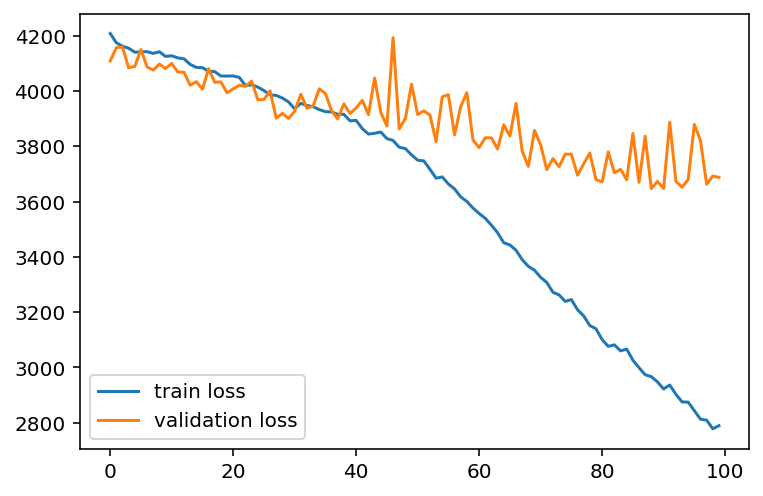

In [0]:
from matplotlib import pyplot as plt
plt.plot(np.arange(100),model.history.history['loss'])
plt.plot(np.arange(100),model.history.history['val_loss'])
plt.legend(("train loss","validation loss"),loc='lower left')
plt.show()

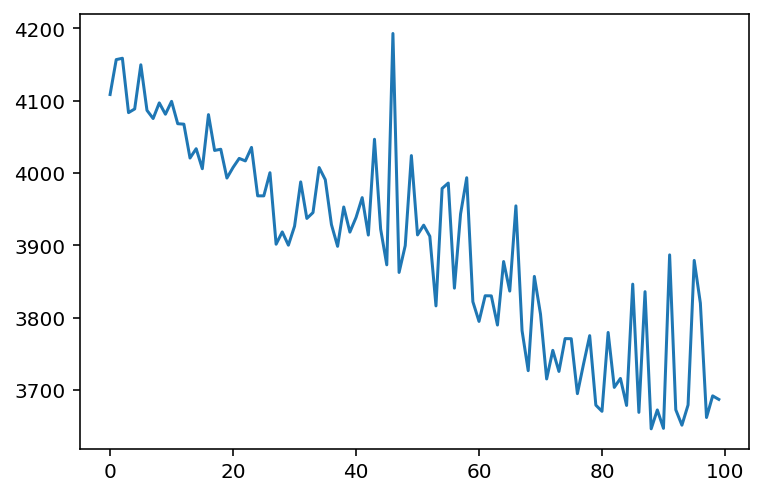

In [0]:
plt.plot(np.arange(100),model.history.history['val_loss'])
plt.show()

In [0]:
model_json = model.to_json()
with open(clean_path + "/full_model_weights_1/model_100.json", "w") as json_file:
    json_file.write(model_json)

## Generating Predictions

In [0]:
# Load best model and its weights

weight_path = "/content/drive/My Drive/makingmusic/full_model_weights_1/weights-1LSTMlayer_class_weights-050-3768.7435.hdf5"
best_model = build_network(X_train_input, n_vocab)
best_model.load_weights(weight_path)

# Load int to note, note to int maps
with open(clean_path + "/Piano_note_to_int_1.pkl", 'rb') as filepath:
    note_to_int = pickle.load(filepath)
    
int_to_note = dict((value, key) for key, value in note_to_int.items())

In [0]:
#source:https://github.com/JakeNims1305/DataScienceMusic/blob/master/1LSTMAtt1LSTMLayer-fulldataset-results/DataScienceMusic.ipynb
def generate(model, X_test, start):
    """
    Generate predictions on sequences model has never seen before. 
    """
    gen_seq_len = 300
    # pick a sequence from the test as a starting point for the prediction
    # start = np.random.randint(0, len(X_test)-1)
    start = start
    
    pattern = np.zeros((sequence_length + gen_seq_len,1))
    pattern[0:sequence_length,:] = X_test[start].reshape(sequence_length,1)
    prediction_output = []

    # generate gen_seq_len notes
    for i in range(gen_seq_len):
        prediction_input = np.reshape(pattern[i:i+sequence_length,:], (1, sequence_length, 1))
        #print("prediction input", prediction_input)
        prediction_input = prediction_input/n_vocab

        prediction = model.predict(prediction_input, verbose=0)
        
        index = np.argmax(prediction)
        
        prediction_output.append(int_to_note[index])
        print(int_to_note[index])
        pattern[sequence_length+i,:] = index # append output to the end of 

    return prediction_output

def create_midi(prediction_output, name):
    """
    Convert predictions to midi file
    """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        pattern = pattern.split()
        temp = pattern[0]
        duration = pattern[1]
        pattern = temp
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = instrument.Piano() #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=clean_path + '/' + name + '_out.mid')

# source:https://stackoverflow.com/questions/1806278/convert-fraction-to-float
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

In [0]:
def generate_prediction():
    prediction_output = generate(best_model,X_test,3)
    create_midi(prediction_output,"3_50epoch")

In [0]:
generate_prediction()

G2 0.5
D4 0.0
E2 0.0
8.0 0.25
A4 0.5
4.10 0.25
F2 0.5
F3 1.0
rest 1.5
F2 0.5
F#2 0.0
E4 0.25
E4 0.25
2.7 1/3
2.7 1/3
E4 0.25
0.5 0.5
F3 1.0
C4 0.25
E4 0.25
4.6 0.25
E4 0.25
8.0 0.25
0.2 0.25
0.2 0.25
8.0 0.25
4.7 1/3
E2 1.0
0.6 0.25
E2 1.0
F#3 0.75
D2 2/3
4.10 0.25
F2 0.5
A2 1.0
5.6 0.5
F#2 1/3
A2 1.0
F2 0.5
F#2 0.0
E4 0.25
F2 0.5
A2 1.0
5.6 0.5
E4 0.25
rest 1.5
E4 0.25
G#2 0.0
A2 0.5
9.11.3 0.25
9.11.3 0.25
3 0.25
E4 0.25
E4 1/3
0.5 0.5
0.5 0.5
0.5 0.5
4.6 0.25
F#2 1/3
C4 1.5
F3 1.0
8.0 0.25
4.6 0.25
F#2 1/3
F#3 0.0
F#3 0.0
A2 0.5
F#3 0.0
F#3 0.0
5.6 0.5
A2 1.0
F2 0.5
5.6 0.5
A2 1.0
5.6 0.5
5.6 0.5
F#2 0.0
F#3 0.5
E4 0.25
C#4 0.25
E4 0.25
C#4 0.25
E4 0.25
E4 0.25
G#4 0.25
E2 1/3
E4 0.25
F#2 1/3
9.11.3 0.25
F#3 0.0
E4 0.25
E4 0.25
E4 0.25
F2 0.5
rest 2/3
rest 2/3
rest 2/3
F2 0.5
E-4 0.25
D2 0.25
A2 0.5
A2 1.0
A4 0.5
E4 0.25
C#4 0.25
E4 0.25
C#4 0.25
E4 0.25
C#4 0.25
A2 0.5
F#3 0.0
E4 0.25
E4 0.25
E4 0.25
C#4 0.25
E4 0.25
C#4 0.25
E4 0.25
C#4 0.25
E4 0.25
A2 0.5
rest 2/3
E4 0.25
F#2 1/3

In [0]:
pm = pretty_midi.PrettyMIDI(clean_path + "/3_50epoch_out.mid")

In [44]:
IPython.display.Audio(pm.synthesize(fs=14000), rate=14000)

In [0]:
import librosa.display
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

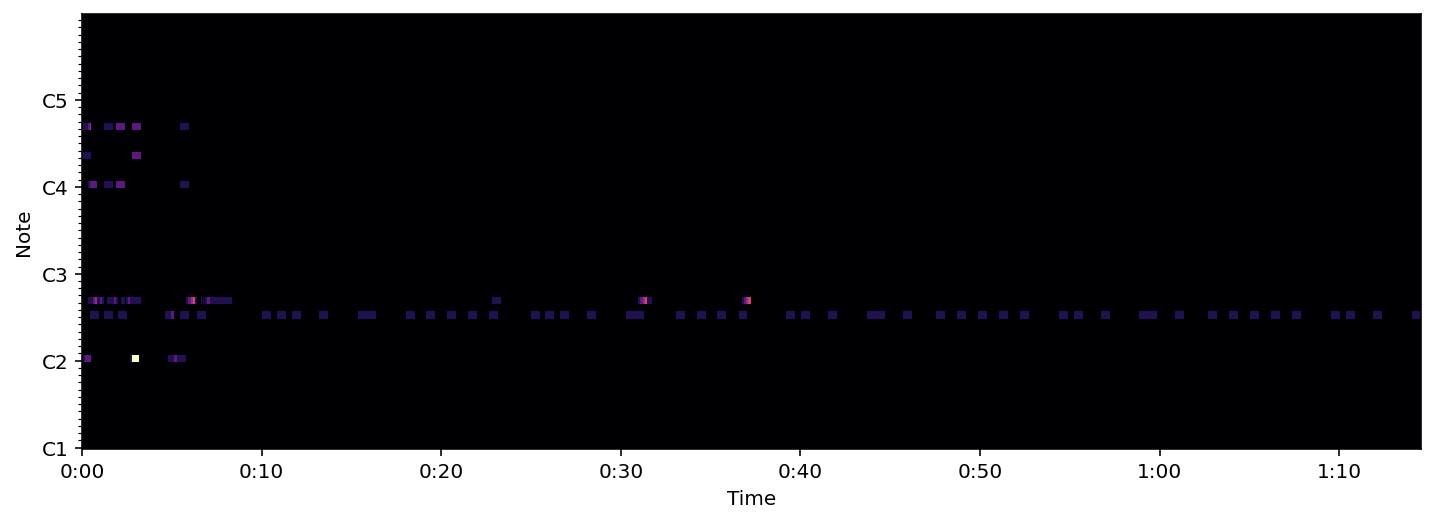

In [172]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)